In [1]:
# --- 1. Imports and Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# Adjust path to import modules from src/ (necessary when running inside a notebook)
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from src.signal_processing import SignalProcessor
except ImportError:
    print("Error: SignalProcessor module could not be loaded. Ensure paths and file names are correct.")
    sys.exit(1)

# --- Define Files and Load Data ---
FILTERED_FILE = '../data/filtered_data.csv'
RESULTS_DIR = '../results'
VALUE_COLUMN = 'Filtered_Value'

try:
    filtered_df = pd.read_csv(FILTERED_FILE, index_col='Timestamp', parse_dates=True)
    print(f"Loading filtered data from: {FILTERED_FILE}")
except FileNotFoundError:
    print(f"Error: File {FILTERED_FILE} not found. Please run main.py first.")
    sys.exit(1)

Loading filtered data from: ../data/filtered_data.csv


In [3]:
# --- 2. Execute FFT Analysis and Get Power Spectrum Data ---

# Initialize the processor and recalculate the sampling rate
processor = SignalProcessor(tau_expected=24.15)
processor.calculate_sampling_rate(filtered_df)

Y = filtered_df[VALUE_COLUMN].values
N = len(Y)
dt_seconds = processor.dt_seconds
sampling_rate = processor.sampling_rate

# 1. Perform FFT
ft = np.fft.fft(Y)

# 2. Calculate Power Spectrum (Magnitude)
# Take the first half of the FFT output, excluding the DC component (index 0)
power_spectrum = np.abs(ft[1:N//2]) 

# 3. Calculate Frequencies
frequencies = np.fft.fftfreq(N, d=dt_seconds)[1:N//2]

# 4. Convert frequencies (Hz) to Period (Hours)
# F_Hz * 3600 seconds/hour gives F_hours. Period is 1/F.
periods_hours = 1.0 / (frequencies * 3600.0)

# 5. Find the Dominant Period (Tau)
dominant_freq_index = np.argmax(power_spectrum)
TAU_FFT = periods_hours[dominant_freq_index]

print(f"\nFFT Calculation Complete. Dominant Period (Tau): {TAU_FFT:.4f} hours.")

Sampling Rate (Fs): 0.0011 Hz.

FFT Calculation Complete. Dominant Period (Tau): 24.0000 hours.



FFT Power Spectrum plot saved to ../results\fft_power_spectrum.png


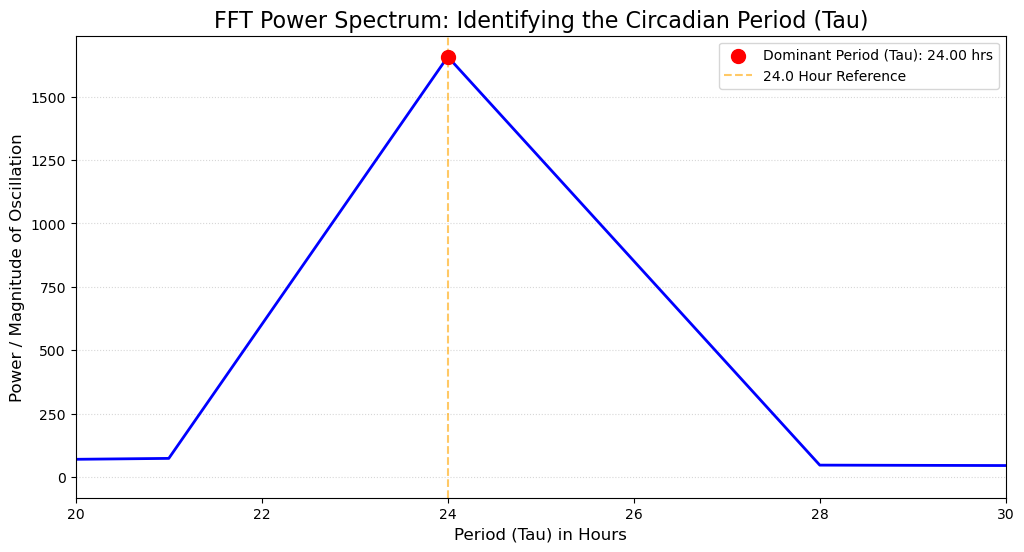

In [5]:
# --- 3. Plotting the Power Spectrum ---

plt.figure(figsize=(12, 6))

# A. Plot Power Spectrum vs. Period (Tau)
plt.plot(periods_hours, power_spectrum, color='blue', linewidth=2)

# B. Highlight the Dominant Peak (The Tau used for Cosinor)
plt.scatter(TAU_FFT, power_spectrum[dominant_freq_index], 
            color='red', s=100, zorder=5, 
            label=f'Dominant Period (Tau): {TAU_FFT:.2f} hrs')

# C. Highlight the expected 24-hour period (for reference)
plt.axvline(x=24.0, color='orange', linestyle='--', alpha=0.6, label='24.0 Hour Reference')

# D. Set Plot Limits for Clarity
# Focus the plot on periods relevant to circadian analysis (e.g., 20 to 30 hours)
plt.xlim(20, 30) 
plt.xlabel('Period (Tau) in Hours', fontsize=12)
plt.ylabel('Power / Magnitude of Oscillation', fontsize=12)
plt.title('FFT Power Spectrum: Identifying the Circadian Period (Tau)', fontsize=16)
plt.legend()
plt.grid(axis='y', linestyle=':', alpha=0.5)

# Save the plot
os.makedirs(RESULTS_DIR, exist_ok=True)
plt.savefig(os.path.join(RESULTS_DIR, 'fft_power_spectrum.png'))
print(f"\nFFT Power Spectrum plot saved to {os.path.join(RESULTS_DIR, 'fft_power_spectrum.png')}")
plt.show()